In [1]:
#!pip install -q efficientnet

In [1]:
import tensorflow as tf
import pandas as pd 
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2, os, shutil, math
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tqdm import tqdm

from tensorflow.keras import models, layers
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Concatenate, Add, Reshape, AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, array_to_img, img_to_array

from tensorflow.keras.applications import EfficientNetB7

In [2]:
# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3

In [4]:
def balance(df, n, working_dir, img_size):
    df = df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)

    for label in df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)
    total = 0
    gen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        shear_range=0.2,  # Thêm shear
        fill_mode='reflect',  # Thay đổi từ 'nearest' sang 'reflect'
        brightness_range=[0.8, 1.2],  # Thêm brightness augmentation
        channel_shift_range=50.0,  # Thêm channel shift
        validation_split=0.2
    )
    groups = df.groupby('labels')
    for label in df['labels'].unique():
        group = groups.get_group(label)
        sample_count = len(group)
        if sample_count < n:
            aug_img_count = 0
            delta = n - sample_count
            target_dir = os.path.join(aug_dir, label)
            msg = '{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='')  # prints over on the same line
            aug_gen = gen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=img_size,
                                              class_mode=None, batch_size=BATCH_SIZE, shuffle=False,
                                              save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                              save_format='jpg')
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
            total += aug_img_count
    print('Total Augmented images created= ', total)
    aug_fpaths, aug_labels = [], []
    classlist = os.listdir(aug_dir)
    for target in classlist:
        classpath = os.path.join(aug_dir, target)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            aug_fpaths.append(fpath)
            aug_labels.append(target)
    Fseries = pd.Series(aug_fpaths, name='filepaths')
    Lseries = pd.Series(aug_labels, name='labels')
    aug_df = pd.concat([Fseries, Lseries], axis=1)
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is ', len(df))
    return df

In [5]:
def make_dataframes(sdir):
    bad_images = []
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))
    
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        if not os.path.isdir(classpath):
            continue
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            try:
                img = cv2.imread(fpath)
                shape = img.shape
                filepaths.append(fpath)
                labels.append(klass)
            except Exception as e:
                bad_images.append(fpath)
                print(f'Defective image file: {fpath}, Error: {e}')
    
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    
    train_df, dummy_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
    
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)
    
    ht, wt, count = 0, 0, 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h, w = img.shape[:2]
            ht += h
            wt += w
            count += 1
        except:
            pass
    if count > 0:
        ave_height = ht // count
        ave_width = wt // count
        aspect_ratio = ave_height / ave_width
    else:
        ave_height, ave_width, aspect_ratio = 0, 0, 0
    
    print(f'Number of classes in processed dataset: {class_count}')
    counts = list(train_df['labels'].value_counts())
    print(f'Max files in any class in train_df: {max(counts)}, Min files in any class: {min(counts)}')
    print(f'Train dataset length: {len(train_df)}, Test dataset length: {len(test_df)}, Validation dataset length: {len(valid_df)}')
    print(f'Average image height: {ave_height}, Average image width: {ave_width}, Aspect ratio (height/width): {aspect_ratio}')
    
    return train_df, test_df, valid_df, classes, class_count

In [6]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen = ImageDataGenerator()
    
    train_ds = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', batch_size=batch_size, shuffle=True)

    valid_ds = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', batch_size=batch_size, shuffle=False)

    test_len = len(test_df)
    test_batch_size = sorted([int(test_len / n) for n in range(1, test_len + 1)
                              if test_len % n == 0 and test_len / n<=80], reverse=True)[0]
    test_steps = int(test_len / test_batch_size)
    
    test_ds = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', batch_size=batch_size, shuffle=False)

    classes = list(train_ds.class_indices.keys())
    class_count = len(classes)
    print('test batch size: ', test_batch_size, 'test steps: ', test_steps, 'number of classes : ', class_count)

    return train_ds, test_ds, valid_ds

In [7]:
# Load and preprocess data
sdir = 'D:/2011/folder1'
train_df, test_df, valid_df, classes, class_count = make_dataframes(sdir)

# Balance the training data
n = 2500  # Số lượng mẫu mong muốn cho mỗi lớp
working_dir = './'  # Thư mục làm việc
train_df = balance(train_df, n, working_dir, (IMAGE_SIZE, IMAGE_SIZE))

# Create data generators
train_ds, test_ds, valid_ds = make_gens(BATCH_SIZE, train_df, test_df, valid_df, (IMAGE_SIZE, IMAGE_SIZE))

scab                   : 100%|██████████████████████████████████████████| 3673/3673 [04:24<00:00, 13.87file/s]


Number of classes in processed dataset: 6
Max files in any class in train_df: 2938, Min files in any class: 949
Train dataset length: 11989, Test dataset length: 1499, Validation dataset length: 1499
Average image height: 1624, Average image width: 2357, Aspect ratio (height/width): 0.6890114552397115
Initial length of dataframe is  11989
Found 2368 validated image filenames.    for class            healthy             creating  132  augmented images 
Found 2001 validated image filenames.    for class              rust              creating  499  augmented images 
Found 1189 validated image filenames.    for class           Black Rot            creating 1311  augmented images 
Found 949 validated image filenames.     for class         powdery_mildew         creating 1551  augmented images 
Total Augmented images created=  3530
Length of augmented dataframe is  15519
Found 15519 validated image filenames belonging to 6 classes.
Found 1499 validated image filenames belonging to 6 classes

In [8]:
def plot_auc_loss(history, epochs):
    tloss = history.history['loss']
    vloss = history.history['val_loss']

    print(f"Number of epochs: {epochs}")
    print(f"Training loss data points: {len(tloss)}")
    print(f"Validation loss data points: {len(vloss)}")

    if len(tloss) != epochs or len(vloss) != epochs:
        print("Mismatch in number of epochs and data points. Adjusting to match.")
        epochs = min(len(tloss), len(vloss))

    Epochs = range(1, epochs + 1)

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    axes[0].plot(Epochs, tloss[:epochs], 'r', label='Training loss')
    axes[0].plot(Epochs, vloss[:epochs], 'g', label='Validation loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    if 'accuracy' in history.history:
        tacc = history.history['accuracy']
        vacc = history.history['val_accuracy']
        axes[1].plot(Epochs, tacc[:epochs], 'r', label='Training accuracy')
        axes[1].plot(Epochs, vacc[:epochs], 'g', label='Validation accuracy')
        axes[1].set_title('Training and Validation accuracy')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('accuracy')
        axes[1].legend()

    plt.show()

In [9]:
def predictor(test_ds, model):
    y_pred, error_list, error_pred_list = [], [], []
    y_true = test_ds.labels
    classes = list(test_ds.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = tf.argmax(model.predict(test_ds), axis=1)
    tests = len(preds)
    for i in range(tests):
        pred_index = preds[i]
        true_index = test_ds.labels[i]
        if pred_index != true_index:
            errors += 1
            file = test_ds.filenames[i]
            error_list.append(file)
            error_classes = classes[pred_index]
            error_pred_list.append(error_classes)
        y_pred.append(pred_index)

    acc = (1 - errors / tests) * 100
    msg = f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%'
    print(msg)
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100

    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return errors, tests, error_list, error_pred_list, f1score

In [10]:
# from tensorflow.keras.backend import clear_session
# import gc
# clear_session()
# gc.collect()


In [3]:
# Build and compile model
base_model = EfficientNetB7(weights='imagenet',
                           include_top=False,
                           input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

for layer in base_model.layers:
    layer.trainable=False
    
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(512,activation="relu")(x)
x = tf.keras.layers.Dense(128,activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
prediction = tf.keras.layers.Dense(len(classes), activation='softmax')(x)

efficient_net_model = Model(inputs=base_model.input, outputs=prediction)

learning_rate_reduction = ReduceLROnPlateau(monitor='loss',
                                          patience=2,
                                          verbose=1,
                                          factor=0.75,
                                          min_lr=0.00001)

efficient_net_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

In [12]:
# Train model
history = efficient_net_model.fit(train_ds,
                                steps_per_epoch=len(train_ds),
                                validation_data=valid_ds,
                                epochs=12,
                                callbacks=[learning_rate_reduction],
                                validation_steps=len(valid_ds),
                                verbose=1)

Epoch 1/12
970/970 [==============================] - 606s 598ms/step - loss: 1.5339 - accuracy: 0.6466 - val_loss: 0.7323 - val_accuracy: 0.6938 - lr: 0.0010
Epoch 2/12
970/970 [==============================] - 525s 540ms/step - loss: 0.6587 - accuracy: 0.7735 - val_loss: 0.5231 - val_accuracy: 0.8279 - lr: 0.0010
Epoch 3/12
970/970 [==============================] - 544s 561ms/step - loss: 0.4688 - accuracy: 0.8462 - val_loss: 0.5542 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/12
970/970 [==============================] - 568s 585ms/step - loss: 0.4306 - accuracy: 0.8559 - val_loss: 0.4437 - val_accuracy: 0.8626 - lr: 0.0010
Epoch 5/12
970/970 [==============================] - 553s 569ms/step - loss: 0.3668 - accuracy: 0.8760 - val_loss: 0.3571 - val_accuracy: 0.8759 - lr: 0.0010
Epoch 6/12
970/970 [==============================] - 520s 536ms/step - loss: 0.3619 - accuracy: 0.8883 - val_loss: 0.5250 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 7/12
970/970 [==========================

Number of epochs: 12
Training loss data points: 12
Validation loss data points: 12


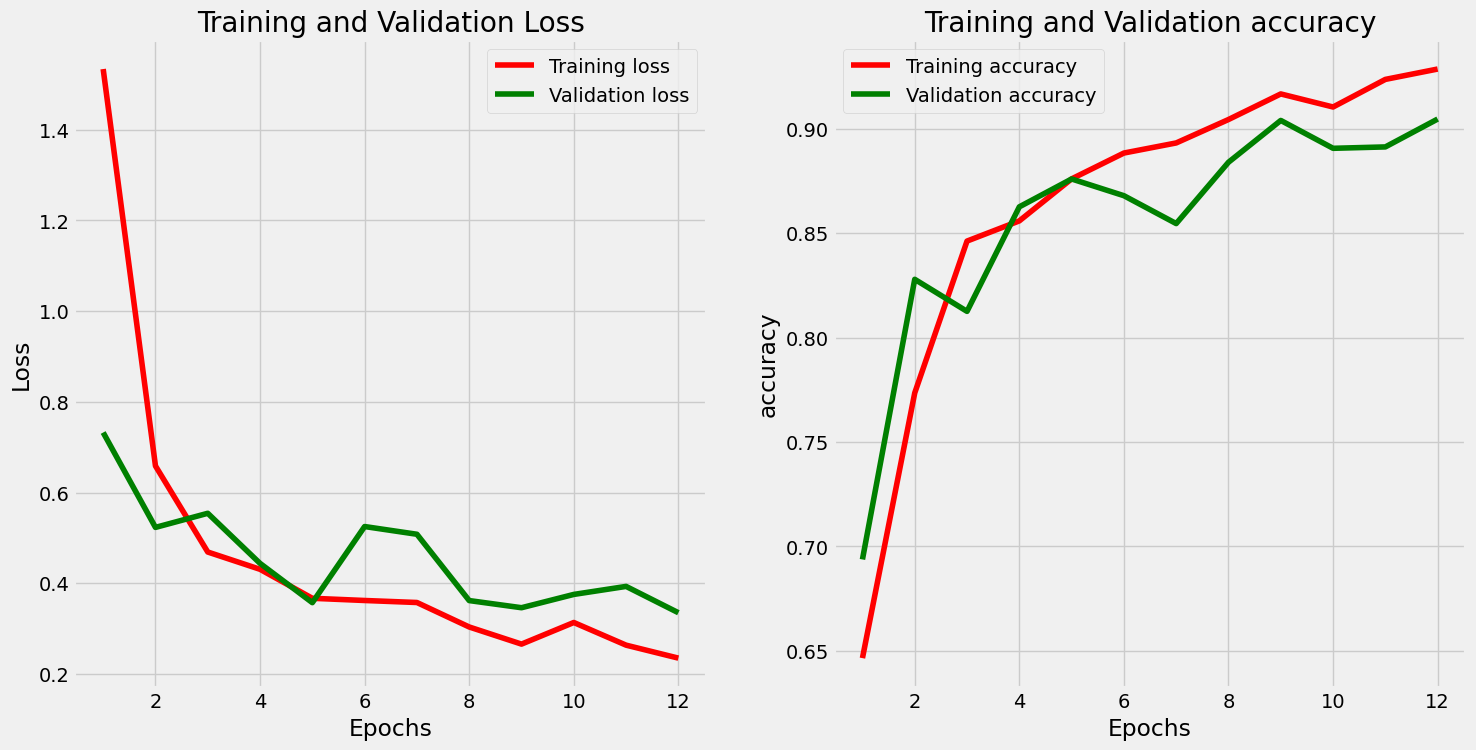

In [13]:
# Plot training history
plot_auc_loss(history, epochs=12)

94/94 [==============================] - 58s 557ms/step
there were 146 errors in 1499 tests for an accuracy of  90.26%


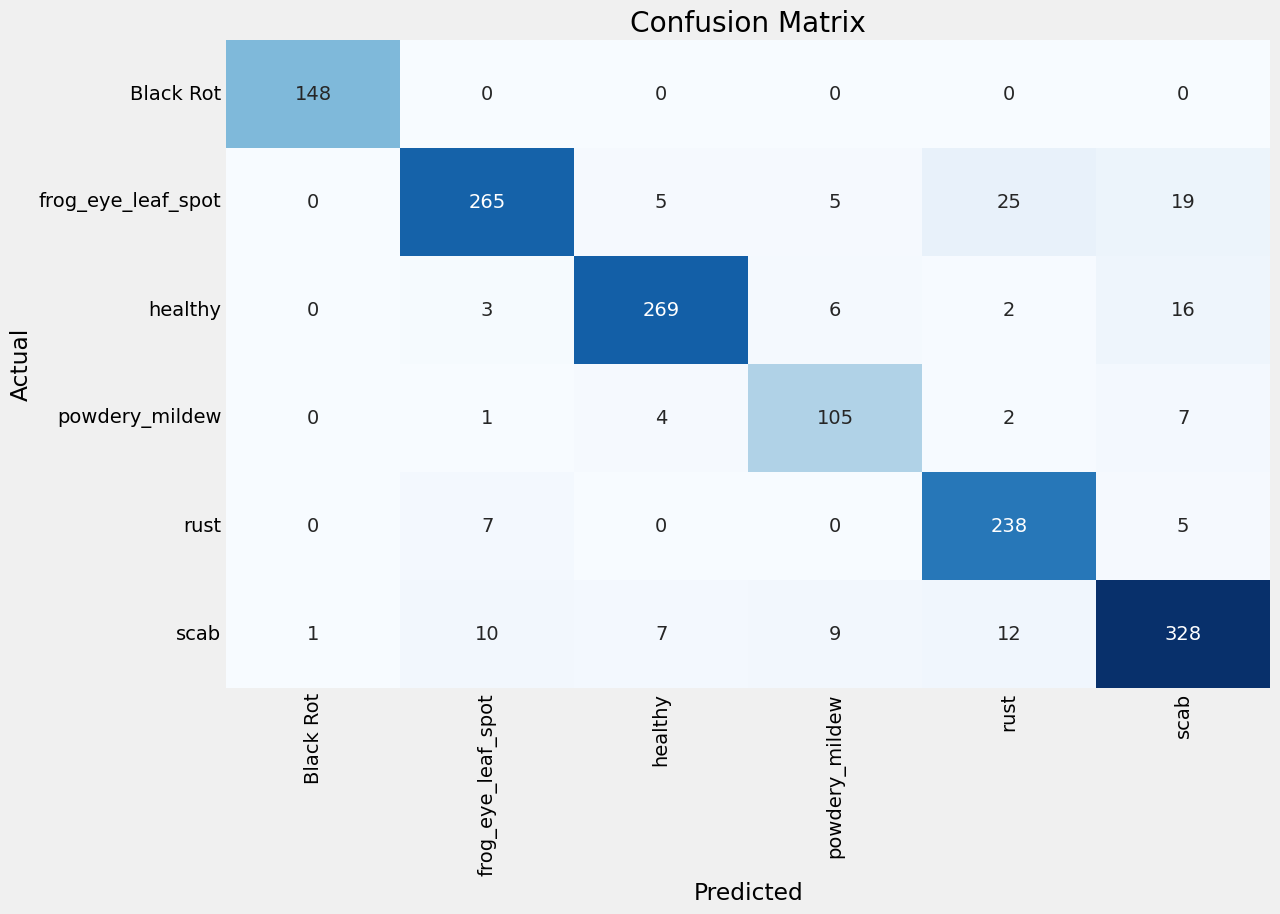

Classification Report:
----------------------
                     precision    recall  f1-score   support

         Black Rot     0.9933    1.0000    0.9966       148
frog_eye_leaf_spot     0.9266    0.8307    0.8760       319
           healthy     0.9439    0.9088    0.9260       296
    powdery_mildew     0.8400    0.8824    0.8607       119
              rust     0.8530    0.9520    0.8998       250
              scab     0.8747    0.8937    0.8841       367

          accuracy                         0.9026      1499
         macro avg     0.9052    0.9113    0.9072      1499
      weighted avg     0.9047    0.9026    0.9025      1499



In [14]:
# Evaluate model
errors, tests, error_list, error_pred_list, f1score = predictor(test_ds, efficient_net_model)

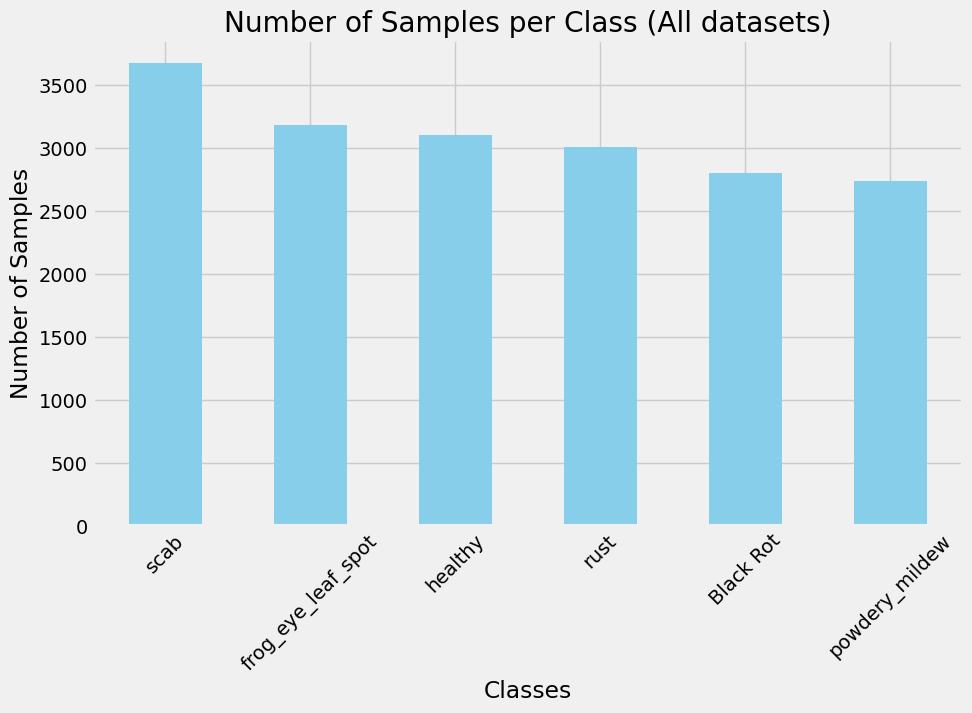

In [15]:
# Plot class distribution
all_data = pd.concat([train_df, test_df, valid_df])
class_counts_all = all_data['labels'].value_counts()

plt.figure(figsize=(10, 6))
class_counts_all.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per Class (All datasets)')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

In [ ]:
efficient_net_model.summary()

In [17]:
# # Save model
# saved_model_path = './model/efficientnet_b7'
# efficient_net_model.save(saved_model_path, save_format='tf')
# print(f"Model saved as SavedModel at: {saved_model_path}")



In [21]:
# Lưu model dưới dạng SavedModel
saved_model_path = './model/efficientnet_b7'
efficient_net_model.save(saved_model_path, save_format='tf')
print(f"Model đã được lưu dưới dạng SavedModel tại: {saved_model_path}")

INFO:tensorflow:Assets written to: ./model/efficientnet_b7\assets


INFO:tensorflow:Assets written to: ./model/efficientnet_b7\assets


Model đã được lưu dưới dạng SavedModel tại: ./model/efficientnet_b7


In [19]:
import tensorflow as tf

# Chạy mô hình trên CPU
with tf.device('/CPU:0'):
    converter = tf.lite.TFLiteConverter.from_keras_model(efficient_net_model)
    tflite_model = converter.convert()

    tflite_save_path = './model/efficientnet_b7.tflite'
    with open(tflite_save_path, 'wb') as f:
        f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\hyu\AppData\Local\Temp\tmph8j2h6xj\assets


INFO:tensorflow:Assets written to: C:\Users\hyu\AppData\Local\Temp\tmph8j2h6xj\assets


In [4]:
import subprocess

# Đường dẫn đến SavedModel đã lưu
saved_model_path = './model/efficientnet_b7/'

# Đường dẫn thư mục để lưu model TensorFlow.js
tfjs_model_dir = './model/modeljs/B7'

# Chuyển đổi model sang TensorFlow.js
result = subprocess.run([
    'tensorflowjs_converter',
    '--input_format', 'tf_saved_model',
    '--output_format', 'tfjs_graph_model',
    '--saved_model_tags', 'serve',
    saved_model_path,
    tfjs_model_dir
], capture_output=True, text=True)

if result.returncode != 0:
    print(f"Lỗi trong quá trình chuyển đổi: {result.stderr}")
else:
    print(f"Model đã được chuyển đổi sang TensorFlow.js và lưu tại: {tfjs_model_dir}")

Model đã được chuyển đổi sang TensorFlow.js và lưu tại: ./model/modeljs/B7
